# Model Inference & Evaluation Pipeline

This script demonstrates how to:
1. Load trained models of different types 
2. Run inference on new data using the loaded model.
3. Compute and plot the overall ROC curve (AUROC).
4. Compute and plot ROC curves (and corresponding AUROC scores) per strata,
    where each strata is defined as the composite of `tissue_type` and `imputed_labels`.

## Imports and Setup

In [ ]:
import sys

from pathlib import Path

import anndata as ad
import numpy as np
import seaborn as sns

# Set matplotlib backend for Jupyter notebooks
%matplotlib inline

project_root = Path.cwd().parent
print(f"Project root: {project_root}")
sys.path.insert(0, str(project_root))

import scxpand

from scxpand.data_util.data_splitter import get_patient_identifiers
from scxpand.data_util.transforms import extract_is_expanded
from scxpand.util.general_util import get_device, metrics_dict_to_dataframes
from scxpand.util.plots import plot_roc_curve, plot_roc_curves_per_strata


device = get_device()
print(f"Using device: {device}")

sns.set_style("whitegrid")

Project root: /Users/rona/my_repos/scxpand
Using device: mps


## Configuration


### Model configuration

1. **Local Model**: Set `RESULTS_PATH` to use a model you trained locally (default)
2. **Registry Model**: Set `MODEL_NAME` to use a curated pre-trained model from scXpand 
3. **Direct URL**: Set `MODEL_URL` to use any external model via direct URL

In [2]:
# Set ONE of the following inference modes:

# === OPTION 1: load model from local path
# RESULTS_PATH = project_root / "results/mlp"
# MODEL_NAME = None
# MODEL_URL = None

# === OPTION 2: load model from registry using the model name (choose from list_pretrained_models())
RESULTS_PATH = None
MODEL_NAME = "pan_cancer_autoencoder"
MODEL_URL = None

# === OPTION 3: load model from URL
# RESULTS_PATH = None
# MODEL_NAME = None
# MODEL_URL = "https://your-platform.com/model.zip"

### Data input configuration

In [ ]:
# Choose ONE of the following options:

# Option 1: File-based inference (memory efficient for large datasets)
DATA_PATH = project_root / "data" / "scXpand_counts_with_expansion_for_model_08_12_2024.h5ad"

# Option 2: In-memory inference (faster for smaller datasets)
# Uncomment and modify one of these lines, then set DATA_PATH = None:
# adata = ad.read_h5ad("your_data.h5ad")  # Load from file into memory
# adata = your_existing_adata_object      # Use existing AnnData object
adata = None  # Set this to your AnnData object for in-memory mode

# If using in-memory mode, set DATA_PATH = None
# DATA_PATH = None

# Optional: Use subset of data for evaluation
# If SPLIT_PATH is not None, only the patient IDs in the subset will be used for evaluation
SPLIT_PATH = project_root / "results" / "optuna_studies" / "dev_patient_ids.csv"
# Otherwise, the full dataset will be used for evaluation:
# SPLIT_PATH = None  # Use full dataset

### Additional configuration

In [4]:
# Inference parameters
BATCH_SIZE = 2048
NUM_WORKERS = 4

In [5]:
# Set save path (if None, results will not be saved)
SAVE_PATH = None
# SAVE_PATH = project_root / "results/inference_results"

if SAVE_PATH:
    SAVE_PATH.mkdir(parents=True, exist_ok=True)

## Load Data

The notebook automatically detects your data input mode:
- **File mode**: If `DATA_PATH` is provided and `adata` is None
- **Memory mode**: If `adata` is provided and `DATA_PATH` is None

In [6]:
# Load data based on configuration
if adata is None and DATA_PATH is not None:
    # File-based mode: load as backed for memory efficiency
    print(f"Loading data from file: {DATA_PATH}")
    adata = ad.read_h5ad(DATA_PATH, backed="r")
    print(f"Loaded {adata.n_obs} cells, {adata.n_vars} genes (file-backed)")
elif adata is not None:
    # Memory mode: adata already provided in configuration
    print(f"Using provided AnnData object: {adata.n_obs} cells, {adata.n_vars} genes")
else:
    raise ValueError("Must provide either DATA_PATH or adata in configuration")

Loading data from file: /Users/rona/my_repos/scxpand/data/scXpand_counts_with_expansion_for_model_08_12_2024.h5ad
Loaded 1588309 cells, 11950 genes (file-backed)


In [7]:
# Get subset of data for evaluation (if specified)

if SPLIT_PATH:
    with open(SPLIT_PATH) as f:
        dev_patient_ids = [line.strip() for line in f]
    patient_identifiers = get_patient_identifiers(obs_df=adata.obs)
    eval_row_inds = np.where(patient_identifiers.isin(dev_patient_ids))[0]
else:
    eval_row_inds = np.arange(len(adata))

n_cells_eval = len(eval_row_inds)
assert n_cells_eval > 0, "No cells found for evaluation"
print(f"Evaluating on {n_cells_eval} cells ({n_cells_eval / len(adata) * 100:.2f}% of total)")

Evaluating on 331065 cells (20.84% of total)


In [8]:
# Run inference using the unified scXpand API

# Use the unified inference function - automatically handles all model types!
results = scxpand.run_inference(
    data_path=DATA_PATH,
    adata=adata,
    model_path=RESULTS_PATH,
    model_name=MODEL_NAME,
    model_url=MODEL_URL,
    save_path=SAVE_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    device=device,
    eval_row_inds=eval_row_inds,
)

# Extract results
y_pred_prob = results.predictions

print(f"Generated predictions for {len(y_pred_prob)} cells")
print(f"Example predictions: {y_pred_prob[:5]}")

2025-09-10 20:21:23 [info     ] Using registry model: pan_cancer_autoencoder [scxpand.core.inference]
2025-09-10 20:21:23 [info     ] Using registry model: pan_cancer_autoencoder [scxpand.pretrained.inference_api]
2025-09-10 20:21:23 [info     ] Model version: 1.0.0           [scxpand.pretrained.inference_api]
2025-09-10 20:21:23 [info     ] Model type will be auto-detected from model_type.txt [scxpand.pretrained.inference_api]
2025-09-10 20:21:23 [info     ] Using cache directory: /Users/rona/my_repos/scxpand/notebooks/.scxpand_cache [scxpand.pretrained.download_manager]
2025-09-10 20:21:23 [info     ] Downloading registry model 'pan_cancer_autoencoder' from: https://figshare.com/ndownloader/articles/30067666/versions/1?folder_path=autoencoder [scxpand.pretrained.download_manager]


Unzipping contents of '/Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/f876361c9c71e3c48397566cb0567d10-1' to '/Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/f876361c9c71e3c48397566cb0567d10-1.unzip'


2025-09-10 20:21:24 [info     ] Normalizing filename: 57702427_data_format.json -> data_format.json [scxpand.pretrained.download_manager]
2025-09-10 20:21:24 [info     ] Normalizing filename: 57702439_parameters.json -> parameters.json [scxpand.pretrained.download_manager]
2025-09-10 20:21:24 [info     ] Normalizing filename: 57702430_data_format.npz -> data_format.npz [scxpand.pretrained.download_manager]
2025-09-10 20:21:24 [info     ] Normalizing filename: 57702445_best_ckpt.pt -> best_ckpt.pt [scxpand.pretrained.download_manager]
2025-09-10 20:21:24 [info     ] Normalizing filename: 57702436_model_type.txt -> model_type.txt [scxpand.pretrained.download_manager]
2025-09-10 20:21:24 [info     ] Model successfully downloaded and cached at: /Users/rona/my_repos/scxpand/notebooks/.scxpand_cache/f876361c9c71e3c48397566cb0567d10-1.unzip/autoencoder [scxpand.pretrained.download_manager]
2025-09-10 20:21:24 [info     ] Running inference with batch size: 2048 [scxpand.pretrained.inference_ap

## Evaluate Predictions

In [9]:
if results.has_metrics:
    overall_df, category_df = metrics_dict_to_dataframes(results.metrics, precision=4)

    # Display overall metrics
    if overall_df is not None:
        print("Overall Metrics:")
        display(overall_df)

    # Display category-specific metrics
    if category_df is not None:
        print("\nCategory-Specific Metrics:")
        display(category_df)

Overall Metrics:


,Metric,Value
0,AUROC,0.9238
1,F1,0.7496
2,RMSE,0.3302
3,error_rate,0.1531
4,false_negative_rate,0.1240
5,false_positive_rate,0.1634
6,positives_rate,0.2616



Category-Specific Metrics:


,AUROC,F1,RMSE,error_rate,false_negative_rate,false_positive_rate,positives_rate
is_CD4__Blood,0.9750,0.7719,0.0984,0.0114,0.1789,0.0074,0.0234
is_CD8__Blood,0.9116,0.8613,0.3511,0.1660,0.0378,0.3138,0.5355
Double_Positive__Blood,0.9274,0.7627,0.3419,0.1469,0.0307,0.1843,0.2435
Double_Negative__Blood,0.9097,0.1628,0.2494,0.0877,0.4167,0.0828,0.0146
is_Treg__Blood,nan,0.0000,0.0309,0.0003,nan,0.0003,0.0000
is_CD4__Tumor,0.8750,0.4598,0.2595,0.0951,0.5300,0.0541,0.0861
Double_Positive__Tumor,0.7920,0.2736,0.3772,0.2149,0.3592,0.2051,0.0631
is_CD8__Tumor,0.7771,0.7706,0.4559,0.2999,0.0647,0.5745,0.5387
is_Treg__Tumor,0.7779,0.1762,0.2703,0.0892,0.8655,0.0299,0.0709
Double_Negative__Tumor,0.8972,0.5852,0.2936,0.1195,0.4203,0.0683,0.1454


## Overall ROC Curve

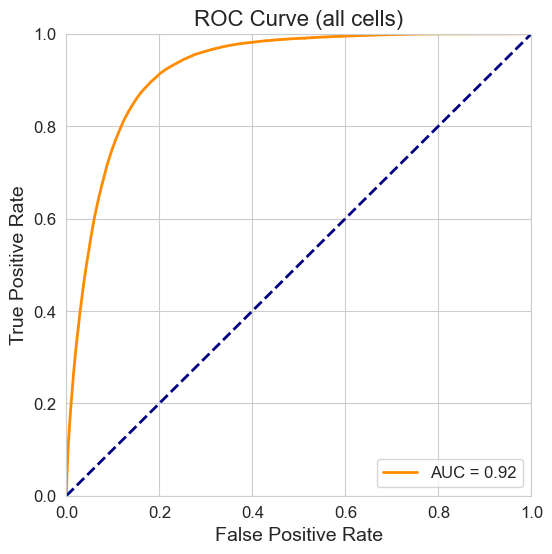

Overall AUROC (all cells): 0.92384. Plot saved to None


In [10]:
if results.has_metrics:
    eval_obs = adata[eval_row_inds].obs
    y_true = extract_is_expanded(eval_obs)

    overall_auroc = plot_roc_curve(
        labels=y_true,
        probs_pred=y_pred_prob,
        show_plot=True,
        plot_save_dir=SAVE_PATH,
        plot_name="roc_curve_overall",
        title="ROC Curve (all cells)",
    )
    print(f"Overall AUROC (all cells): {overall_auroc:.5f}. Plot saved to {SAVE_PATH}")

## Per-Strata AUROC Evaluation

In [11]:
# Per-strata evaluation
if results.has_metrics:
    strata_cols = ["tissue_type", "imputed_labels"]
    strata_df = eval_obs[strata_cols]
    strata = strata_df.astype(str).agg(" - ".join, axis=1)
    strata.index = eval_obs.index

    unique_strata = strata.unique()
    print(f"Unique strata found: {unique_strata}")

    print(f"Harmonic Average AUROC per Strata: {results.get_harmonic_avg_auroc():.5f}")

Unique strata found: ['Blood - is_CD4' 'Blood - is_CD8' 'Blood - Double_Positive'
 'Blood - Double_Negative' 'Blood - is_Treg' 'Tumor - is_CD4'
 'Tumor - Double_Positive' 'Tumor - is_CD8' 'Tumor - is_Treg'
 'Tumor - Double_Negative']
Harmonic Average AUROC per Strata: 0.86601


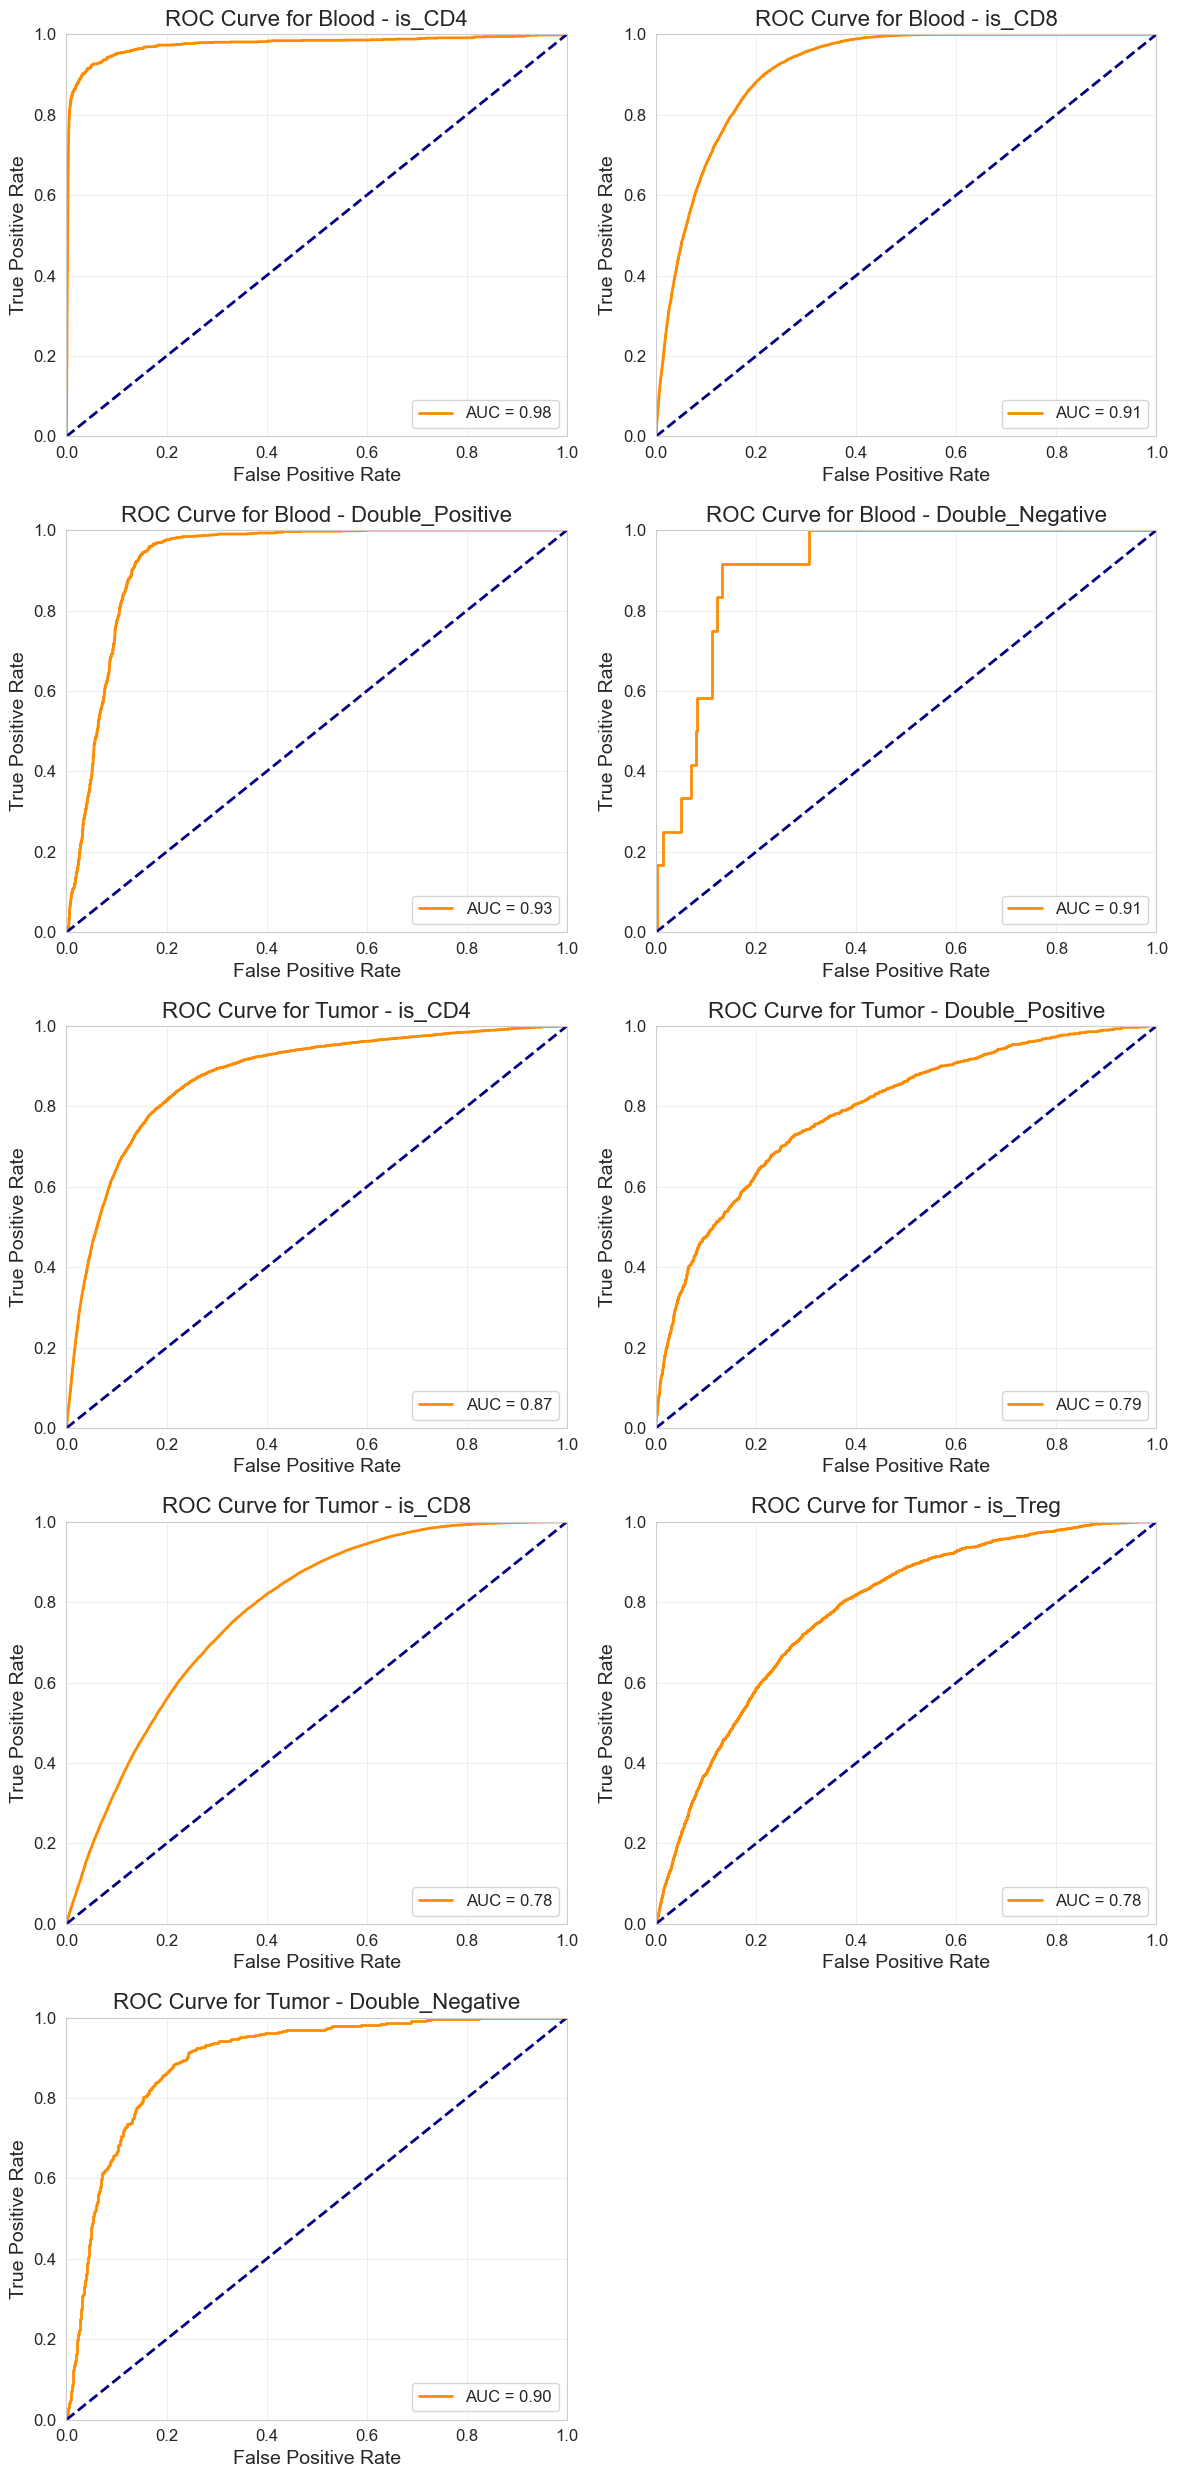

In [15]:
if results.has_metrics:
    auroc_per_strata = plot_roc_curves_per_strata(
        y_true=y_true,
        y_pred_prob=y_pred_prob,
        obs_df=eval_obs,
        strata_columns=strata_cols,
        show_plot=True,
        plot_save_dir=SAVE_PATH,
        max_cols=2,
    )

## Save Predictions

In [16]:
import pandas as pd


def save_predictions(
    predictions: np.ndarray,
    adata: ad.AnnData,
    save_path: Path,
) -> None:
    if not SAVE_PATH:
        return
    pred_column_name = "expansion_probability"
    predictions_df = pd.DataFrame({"cell_id": adata.obs.index, pred_column_name: predictions})
    csv_path = save_path / "predictions.csv"
    try:
        predictions_df.to_csv(csv_path, index=False)
        print(f"Saved predictions to {csv_path}")
    except Exception:
        print(f"Failed to save predictions to {csv_path}")
        raise


# Note: We need to create a subset of adata that matches the predictions
# Since predictions are already subset to eval_row_inds, we need matching adata subset
eval_adata_subset = adata[eval_row_inds]
save_predictions(predictions=y_pred_prob, adata=eval_adata_subset, save_path=SAVE_PATH)

In [17]:
# Clean up: close file if it was opened in backed mode
if hasattr(adata, "isbacked") and adata.isbacked:
    adata.file.close()
    print("Closed backed AnnData file")

Closed backed AnnData file
